<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/Lecture-AI_programming/boston_housing_price_with_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 보스턴 집값 데이터셋

In [75]:
import torch
import torch.optim as optim
import torch.nn.init as init

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, init, Linear, Parameter, MSELoss, ReLU, BatchNorm1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from typing import Iterable, Iterator
from pickle import dump, load
from pandas.plotting import scatter_matrix as sm

In [76]:
for c in [np, torch, pd]:
  print(c.__name__, c.__version__)

numpy 1.25.2
torch 2.2.1+cu121
pandas 2.0.3


# 데이터 불러오기
### 레코드 수: 506개
### 필드 개수: 14개

- CRIM: 인구 1인당 범죄율
- ZN: 25,000 평방피트를 초과하는 주거용 토지의 비율
- INDUS: 비소매상업지역이 점유하고 있는 토지의 비율
- CHAS: 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 10ppm 당 농축 일산화질소
- RM: 주택 1가구당 평균 방의 개수
- AGE: 1940년 이전에 건축된 소유주택의 비율
- DIS: 5개의 보스턴 직업센터까지의 접근성 지수
- RAD: 방사형 도로까지의 접근성 지수
- TAX: 10,000 달러 당 재산세율
- PTRATIO: 자치시(town)별 학생/교사 비율
- B: 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함.
- LSTAT: 모집단의 하위계층의 비율(%)
- MEDV: 본인 소유의 주택가격(중앙값) (단위: $1,000)

In [77]:
data_url = 'https://blog.kakaocdn.net/dn/bBaIM3/btsGBsBNUDl/irTKKK1MF1Y1o6JHpGn3n1/boston.csv?attach=1&knm=tfile.csv'

# read_csv
df = pd.read_csv(
    data_url,      # url or file path
    skiprows = 0, # num of rows to skip
    header = 0, # header row
    sep = ','    # separator
)
df

,CRIM,ZN,INDUS,CHAS,NOX,RN,AGE,DIS,RAD,TAX,PIRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


# 데이터 시각화
### (1) 분산 확인

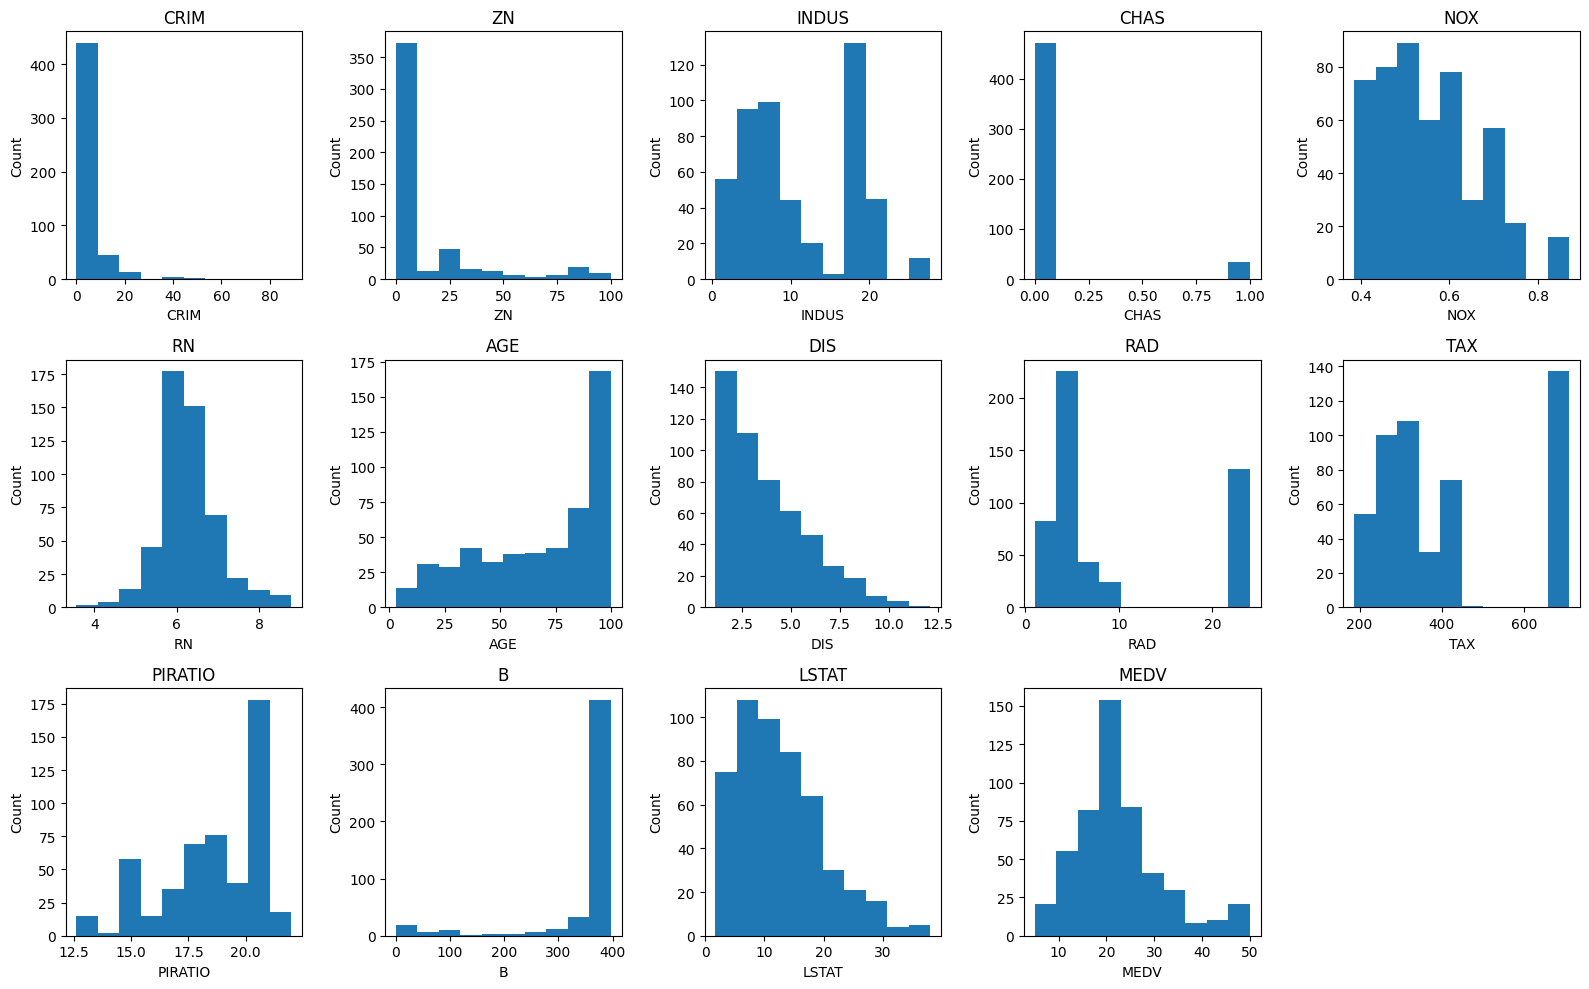

In [78]:
fig=plt.figure(figsize=(16,10))
for i in range(len(df.columns)):
  plt.subplot(3, 5, i+1)
  plt.hist(df[[df.columns[i]]])
  plt.title(df.columns[i])
  plt.xlabel(df.columns[i])
  plt.ylabel('Count')

plt.tight_layout()
plt.show()

## (2) MEDV 필드와 관계 확인

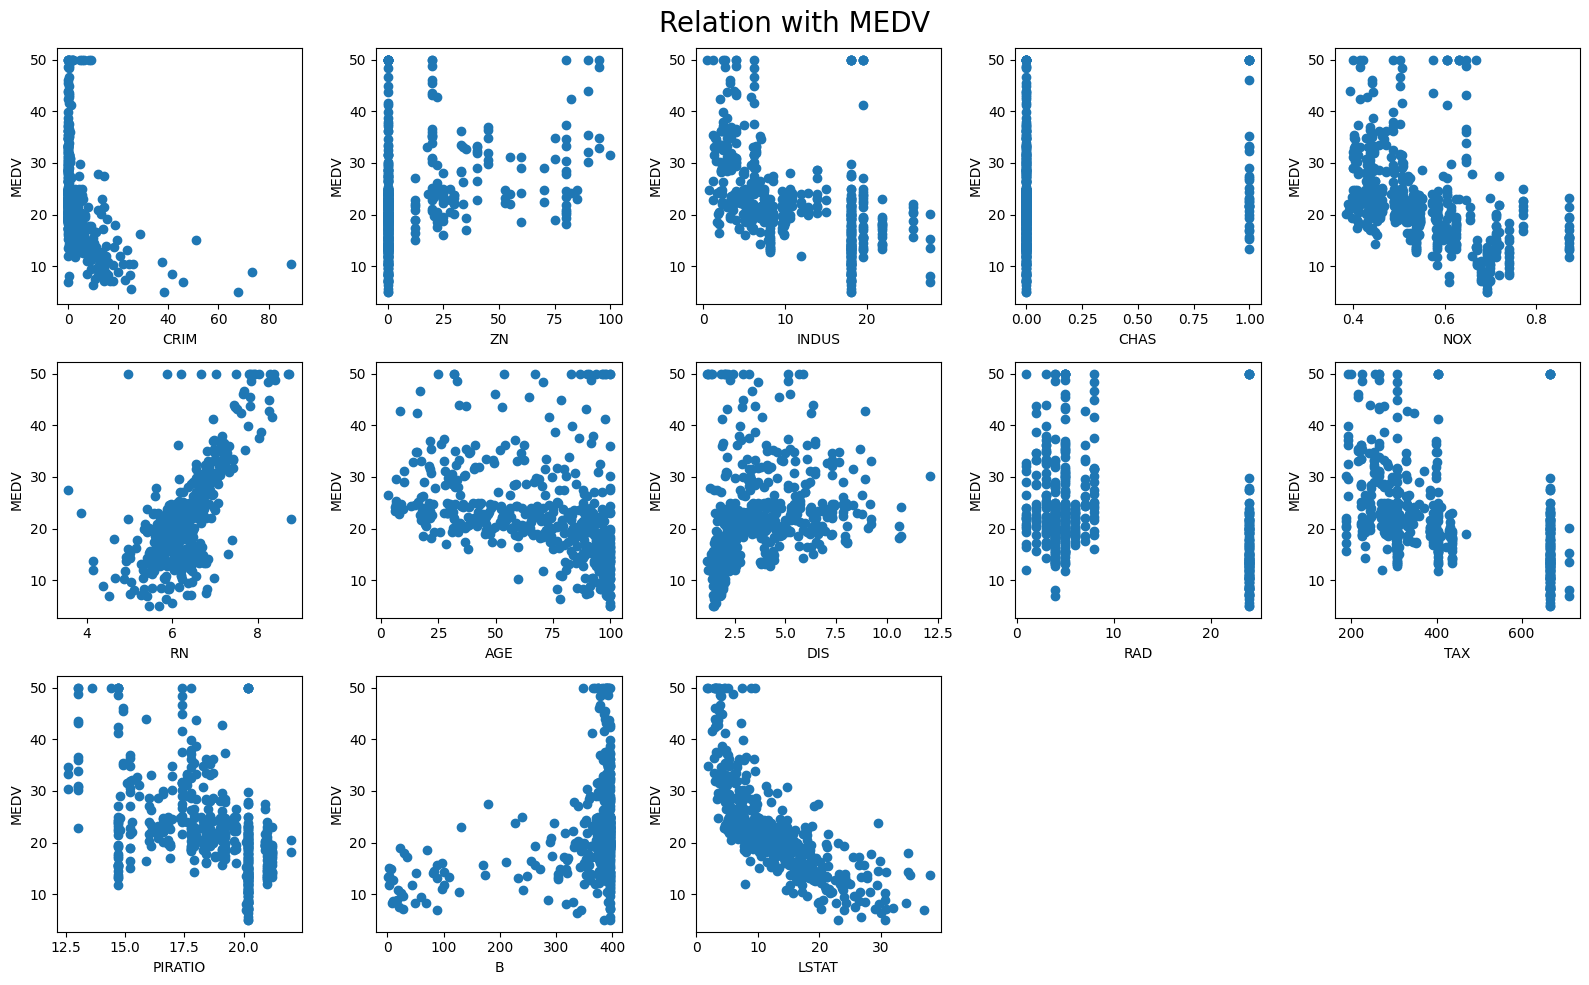

In [79]:
fig=plt.figure(figsize=(16,10))
plt.suptitle('Relation with MEDV', fontsize=20)

for i in range(len(df.columns)-1):
  plt.subplot(3, 5, i+1)
  plt.scatter(df[[df.columns[i]]], df[[df.columns[-1]]])
  plt.xlabel(df.columns[i])
  plt.ylabel('MEDV')


plt.tight_layout()
plt.show()

## (3) Heatmap으로 상관관계 파악

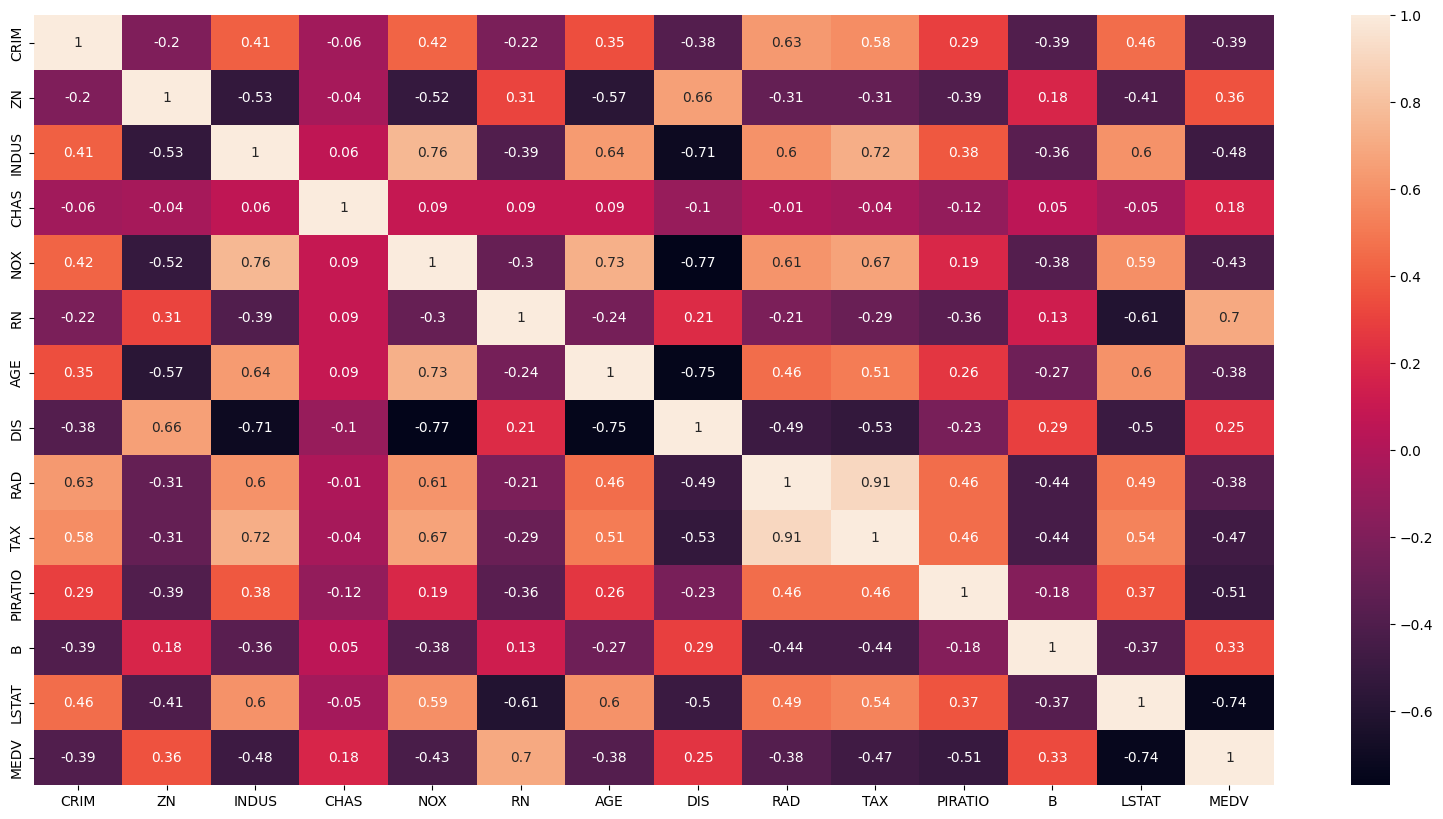

In [80]:
# 상관관계 행렬 생성
# 소수점 둘째 자리까지만 표시
correlation_matrix = df.corr().round(2)

# 이미지 크기 지정
plt.figure(figsize=(20,10))

# 상관관계 행렬 표시
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

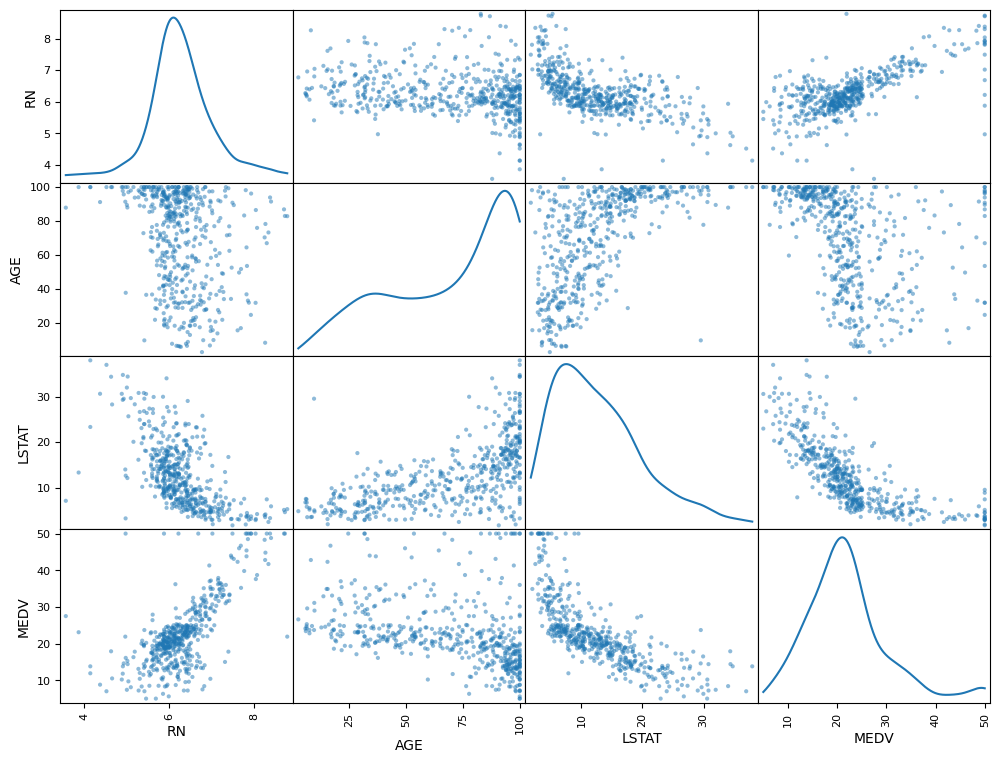

In [81]:
sm(df[['RN','AGE','LSTAT','MEDV']], diagonal='kde', figsize=(12,9))
plt.show()

# Data Split & Scaling

In [82]:
tmp = df.values
x_raw = tmp[:,:-1]
y_raw = tmp[:,-1:]

print(x_raw.shape)
print(y_raw.shape)


(506, 13)
(506, 1)


In [83]:
x_train, x_test, y_train, y_test = train_test_split(
    x_raw, y_raw,
    test_size = 0.1,
    random_state = 23,
)

print(x_train.shape, x_test.shape)

(455, 13) (51, 13)


# Dataset & DataLoader

In [84]:
class BostonDataset(Dataset):
  def __init__(self, features, targets, transformer=None):
    self.features = features
    self.targets = targets
    self.transformer = transformer

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):

    if self.transformer is None:
      _feature = self.features[idx]
    else:
      _feature = self.transformer.transform([self.features[idx]])[0] # transform은 sample의 리스트로 arg를 해야함.

    _feature = torch.tensor(_feature).float()
    _target = torch.tensor(self.targets[idx]).float()
    return _feature, _target

In [85]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train,
    test_size = 0.1,
    random_state = 23,
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

train_dataset = BostonDataset(x_train, y_train, scaler)
valid_dataset = BostonDataset(x_valid, y_valid, scaler) # 전처리는 testset 빼고 진행.
print(len(train_dataset))
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 100,
    shuffle = True,
)
valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 32,
    shuffle = True, # 학습 단계가 아니기 때문에 굳이 사용하지 않아도 상관없음.
)
print(f'{isinstance(train_loader, Iterable)=}')
print(f'{isinstance(iter(train_loader), Iterable)=}')
tmp_feature, tmp_label = next(iter(train_loader))
print(f'{tmp_feature.shape=}, {tmp_label.shape=}')

409
isinstance(train_loader, Iterable)=True
isinstance(iter(train_loader), Iterable)=True
tmp_feature.shape=torch.Size([100, 13]), tmp_label.shape=torch.Size([100, 1])


# MLP model 선언

In [86]:
class DsANN(Module):
  def __init__(self,
               n_in_f, # input vector의 차원 수
               n_out_f # output vector의 차원 수
               ):
    super().__init__()

    self.l0 = Linear(n_in_f, 32)
    self.bn0 = BatchNorm1d(32)
    self.relu0 = ReLU()
    self.l1 = Linear(32, 32)
    self.bn1 = BatchNorm1d(32)
    self.relu1 = ReLU()
    self.l2 = Linear(32, n_out_f)

    with torch.no_grad():
      init.constant_(self.l0.bias, 0.)
      init.xavier_uniform(self.l0.weight)

  def forward(self, x):
    x = self.l0(x)
    x = self.bn0(x)
    x = self.relu0(x)
    x = self.l1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    y = self.l2(x)
    return y

In [87]:
device = (
      "cuda" if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu"
  )
print(f"{device=}")

device='cuda'


In [88]:
def train_loop(dataloader,
               m,
               lr, n_epochs, optimizer,
               device = "cpu"):

  log_hist = torch.zeros([0,3]).to(device) # 3개의 data가 저장될 빈 텐서.
  m = m.to(device)

  l = MSELoss()


  for epoch in range(1,n_epochs+1):
    print(f'\r {epoch}',end='')
    for x_tensor, y_tensor in dataloader:

      x_tensor = x_tensor.to(device)
      y_tensor = y_tensor.to(device)

      pred = m(x_tensor)

      loss = l(pred, y_tensor)
      if torch.isinf(loss):
        print(f'Error: loss is infinity!')
        break

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      for x_tensor, y_tensor in valid_loader:
        x_tensor = x_tensor.to(device)
        y_tensor = y_tensor.to(device)
        pred = m(x_tensor)

        e_loss = l(pred, y_tensor) # evaluation loss


    if epoch % 100 == 0 or epoch == 1:
      tmp = torch.tensor([epoch, loss.item(), e_loss.item()]).to(log_hist.device)
      log_hist = torch.concat( (log_hist, tmp.reshape(1,-1)), dim=0 )
      print(f' Epoch / loss {loss.item():.4f} / val_loss {e_loss.item():.4f}')

    if epoch == n_epochs:
      print(f' Epoch / loss {loss.item():.4f} / val_loss {e_loss.item():.4f}')

  return m,log_hist

In [89]:
x_tensor, y_tensor = next(iter(train_loader))
m = DsANN(x_tensor.shape[-1], y_tensor.shape[-1])
print(f'{x_tensor.shape=}')
tmp = m(x_tensor)
print(f'{tmp.shape=}')

x_tensor.shape=torch.Size([100, 13])
tmp.shape=torch.Size([100, 1])


<ipython-input-86-14bc204d900e>:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.l0.weight)


In [90]:
%time final_model, log_hist = train_loop(train_loader, m, 1e-3, 2000, optimizer, device) # case 3

 1 Epoch / loss 302.9344 / val_loss 701.6429
 100 Epoch / loss 40.3144 / val_loss 159.0076
 200 Epoch / loss 5.1680 / val_loss 11.7261
 300 Epoch / loss 20.1574 / val_loss 40.4344
 400 Epoch / loss 7.7661 / val_loss 52.5648
 500 Epoch / loss 18.0447 / val_loss 7.5291
 600 Epoch / loss 43.1641 / val_loss 10.3163
 700 Epoch / loss 48.4935 / val_loss 10.2817
 800 Epoch / loss 13.3562 / val_loss 43.7128
 900 Epoch / loss 38.5379 / val_loss 42.4819
 1000 Epoch / loss 18.9376 / val_loss 53.2722
 1100 Epoch / loss 36.8585 / val_loss 59.5281
 1200 Epoch / loss 5.7306 / val_loss 7.4121
 1300 Epoch / loss 16.9738 / val_loss 47.4597
 1400 Epoch / loss 6.9785 / val_loss 73.5215
 1500 Epoch / loss 5.3812 / val_loss 41.4825
 1600 Epoch / loss 3.7366 / val_loss 9.7506
 1700 Epoch / loss 19.4434 / val_loss 16.9537
 1800 Epoch / loss 6.9917 / val_loss 6.8558
 1900 Epoch / loss 14.6695 / val_loss 6.0139
 2000 Epoch / loss 5.6989 / val_loss 36.8945
 Epoch / loss 5.6989 / val_loss 36.8945
CPU times: user 

# Evaluation

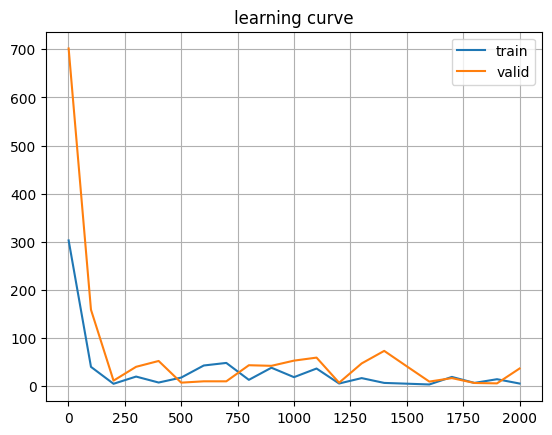

In [91]:
start = 0

# gpu에 있는 것을 가져와주기.
if device != "cpu":
  log_hist = log_hist.to("cpu")

fig, axes = plt.subplots(1,1)
axes.set_title('learning curve')
axes.plot(log_hist.detach()[start:,0], log_hist[start:,1], label='train')
axes.plot(log_hist.detach()[start:,0], log_hist[start:,2], label='valid')
axes.legend()
axes.grid()
fig.show()

In [92]:
if device != "cpu":
  final_model = final_model.to("cpu")

x_scaled_test = scaler.transform(x_test)
y_pred = final_model(torch.tensor(x_scaled_test).float()).detach()

print(f'{r2_score(y_test,y_pred)=}')

r2_score(y_test,y_pred)=0.7939404074019014


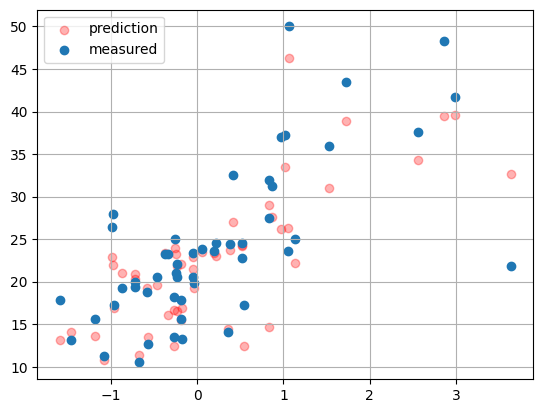

In [93]:
rns = x_scaled_test[:,0]
if x_scaled_test.shape[1] > 5:
  rns = x_scaled_test[:,5]

fig, axes = plt.subplots(1,1)
axes.scatter(rns, y_pred, alpha=0.3, c='r', label='prediction')
axes.scatter(rns, y_test, label='measured')
axes.grid()
axes.legend()